In [18]:
#Sprawdź, czy u Ciebie działa ten notebook na pc
#Jak nie, sprawdź, czy masz Opencv 3.4.2
#Jak coś dalej nie będzie działać, to spróbuję użyć dockera

#Kod działa bardzo dobrze wtw, gdy nie ma łączenia linii - co logiczne, ten kod to prawie pełen recykling z samolotów 
#Zauważ ostatnie obrazki - 1. transformacja blur+edge-detector, ona nam wystarczy do odkrycia 5-linii i nut. Całość
#Chyba najlepiej przeprowadzić na tym czarno białym obrazku z edge detectionem - kernele x(blur),1(ed) do 5-linii i
#5 v 6(blur),2(ed) do nut

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import math

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
print(cv.__version__)

3.4.2


In [67]:
%%cython
import numpy as np
cimport numpy as np
from cpython cimport array
import array


def verse(np.ndarray[int, ndim=1] himg):
    if (himg[0]>himg[1] and himg[0]>himg[2]):
        himg[1]=himg[2]=himg[0]
    elif (himg[1]>himg[2]):
        himg[0]=himg[2]=himg[1]
    else:
        himg[1]=himg[0]=himg[2]
        
        
def verse2(np.ndarray[double, ndim=1] himg):
    if (himg[0]>himg[1] and himg[0]>himg[2]):
        himg[1]=himg[2]=himg[0]
    elif (himg[1]>himg[2]):
        himg[0]=himg[2]=himg[1]
    else:
        himg[1]=himg[0]=himg[2]

        

def overkill(np.ndarray[double, ndim=3] img):
    cdef int i=0, j=0, v1, v2;
    cdef np.ndarray[double, ndim=3] img2=np.zeros((img.shape[0], img.shape[1], 3), dtype='float64')
    
    v1=img.shape[0]
    v2=img.shape[1]
    
    for i in range(v1):
        for j in range(v2):
            img2[i,j,0]=img[i,j,0]
            img2[i,j,1]=img[i,j,1]
            img2[i,j,2]=img[i,j,2]
            
            verse2(img2[i,j])
    return img2
            

def purify(np.ndarray[int, ndim=3] img):
    cdef np.ndarray[int, ndim=1] vv=np.zeros((2, ), dtype='int32')
    cdef np.ndarray[int, ndim=1] z=np.zeros((2, ), dtype='int32')
    cdef np.ndarray[int, ndim=2] t=np.zeros((4, 2), dtype='int32')
    
    
    cdef np.ndarray[int, ndim=3] img2=np.zeros((img.shape[0], img.shape[1], 3), dtype='int32')
    cdef np.ndarray[int, ndim=2] check=np.zeros((img.shape[0], img.shape[1]), dtype='int32')
    cdef np.ndarray[int, ndim=2] ch2=np.zeros((img.shape[0], img.shape[1]), dtype='int32')
    cdef np.ndarray[int, ndim=2] F=np.zeros((img.shape[0]*img.shape[1]*3, 2), dtype='int32')
    cdef int iF=0, jF=1, i=0, j=0, ij=0, summ=0
    
    
    vv[0]=img.shape[0]
    vv[1]=img.shape[1]
    F[0,0]=0
    F[0,1]=0
    
    for i in range(0, vv[0]):
        for j in range(0, vv[1]):
            verse(img[i,j])
            img2[i,j,0]=img[i,j,0]
            img2[i,j,1]=img[i,j,1]
            img2[i,j,2]=img[i,j,2]    
    
    while (iF<jF):
        z[0]=F[iF,0]
        z[1]=F[iF,1]
        
        t[0,0]=z[0]-1
        t[0,1]=z[1]
        
        t[1,0]=z[0]
        t[1,1]=z[1]-1
        
        t[2,0]=z[0]+1
        t[2,1]=z[1]
        
        t[3,0]=z[0]
        t[3,1]=z[1]+1
        
        if (z[0]>0 and img2[t[0,0],t[0,1],0]==0 and check[t[0,0],t[0,1]]==0):
            F[jF,0]=t[0,0]
            F[jF,1]=t[0,1]
            check[t[0,0],t[0,1]]=1
            jF+=1
            
        if (z[1]>0 and img2[t[1,0],t[1,1],0]==0 and check[t[1,0],t[1,1]]==0):
            F[jF,0]=t[1,0]
            F[jF,1]=t[1,1]
            check[t[1,0],t[1,1]]=1
            jF+=1
            
        if (z[0]+1<vv[0] and img2[t[2,0],t[2,1],0]==0 and check[t[2,0],t[2,1]]==0):
            F[jF,0]=t[2,0]
            F[jF,1]=t[2,1]
            check[t[2,0],t[2,1]]=1
            jF+=1
            
        if (z[1]+1<vv[1] and img2[t[3,0],t[3,1],0]==0 and check[t[3,0],t[3,1]]==0):
            F[jF,0]=t[3,0]
            F[jF,1]=t[3,1]
            check[t[3,0],t[3,1]]=1
            jF+=1
        
        iF+=1
    
    for i in range(0, vv[0]):
        for j in range(0, vv[1]):            
            if (img2[i,j,0]==255 and ch2[i,j]==0):
                F[0,0]=i
                F[0,1]=j
                
                iF=0
                jF=1
                while (iF<jF):
                    
                    z[0]=F[iF,0]
                    z[1]=F[iF,1]

                    t[0,0]=z[0]-1
                    t[0,1]=z[1]

                    t[1,0]=z[0]
                    t[1,1]=z[1]-1

                    t[2,0]=z[0]+1
                    t[2,1]=z[1]

                    t[3,0]=z[0]
                    t[3,1]=z[1]+1
                    
                    if (z[0]>0 and ch2[t[0,0],t[0,1]]==0 and check[t[0,0],t[0,1]]==0):
                        F[jF,0]=t[0,0]
                        F[jF,1]=t[0,1]
                        ch2[t[0,0],t[0,1]]=1
                        jF+=1

                    if (z[1]>0 and ch2[t[1,0],t[1,1]]==0 and check[t[1,0],t[1,1]]==0):
                        F[jF,0]=t[1,0]
                        F[jF,1]=t[1,1]
                        ch2[t[1,0],t[1,1]]=1
                        jF+=1

                    if (z[0]+1<vv[0] and ch2[t[2,0],t[2,1]]==0 and check[t[2,0],t[2,1]]==0):
                        F[jF,0]=t[2,0]
                        F[jF,1]=t[2,1]
                        ch2[t[2,0],t[2,1]]=1
                        jF+=1

                    if (z[1]+1<vv[1] and ch2[t[3,0],t[3,1]]==0 and check[t[3,0],t[3,1]]==0):
                        F[jF,0]=t[3,0]
                        F[jF,1]=t[3,1]
                        ch2[t[3,0],t[3,1]]=1
                        jF+=1
                    
                    iF+=1
                
                if (jF<100):
                    summ+=jF
                    for jj in range(0, jF):
                        img2[F[jj,0],F[jj,1],0]=0
                        img2[F[jj,0],F[jj,1],1]=0
                        img2[F[jj,0],F[jj,1],2]=0
                #Pouring colors upon blackening world
                #else:
                #    for jj in range(0, jF):
                #        img2[F[jj,0],F[jj,1],0]=255
                #        img2[F[jj,0],F[jj,1],1]=255
                #        img2[F[jj,0],F[jj,1],2]=255
    return img2

In [4]:
v=list(os.walk('./zdjs'))

f=[0]*200
j=0
for i in range(1, len(v)):
    for x in (v[i][2]):
        f[j]=cv.imread(v[i][0]+'/'+x, cv.IMREAD_COLOR)[...,::-1]/255
        j+=1


In [5]:
def grave(img):
    fig, ax=plt.subplots(1,1,figsize=(18,18))
    ax.imshow(img)
    plt.show()

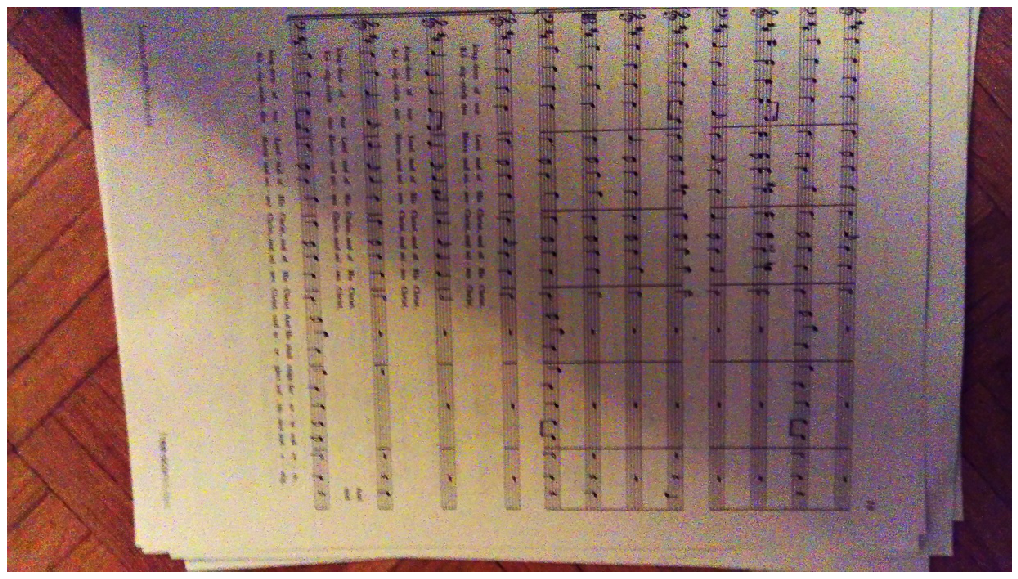

In [6]:
fig, ax=plt.subplots(1,1,figsize=(18,18))

kv=f[46]

ax.imshow(kv)
ax.axis('off')
plt.show()

0
1
2


IndexError: list index out of range

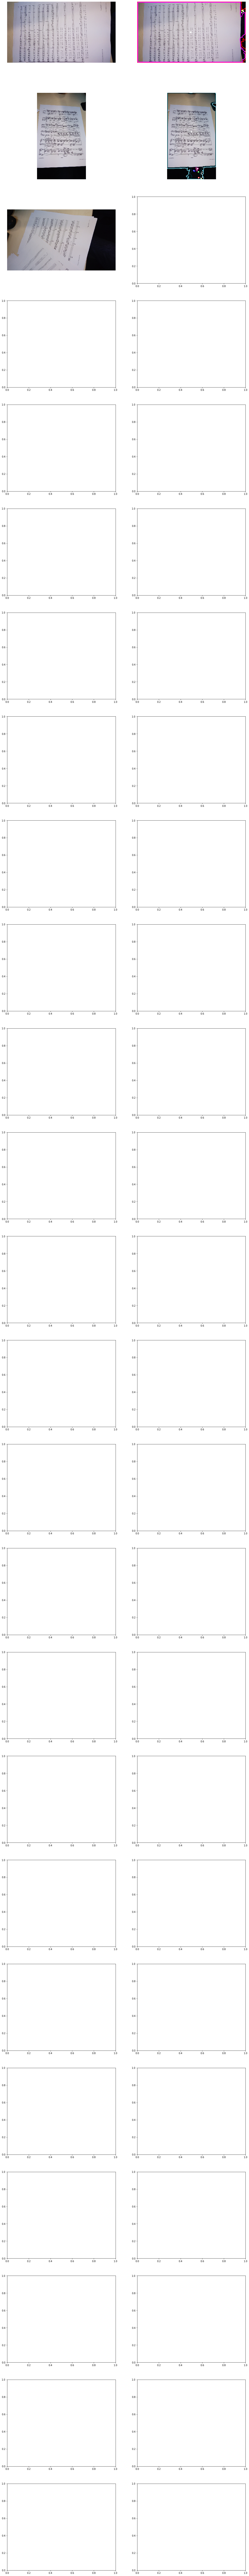

In [84]:
def colortotuple(x):
    r=int(x[1:3], 16)
    g=int(x[3:5], 16)
    b=int(x[5:7], 16)
    
    return (r, g, b)


t1=time.time()
#ss - liczba obrazków
ss=25

fig, ax=plt.subplots(ss,2,figsize=(18,8*ss))

kernel1=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel2=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel3=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel4=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel5=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel6=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])

g=[0]*ss
em=[0]*ss
palette=['#FF0101', '#01FF01', '#0101FF', '#FF33BB',
        '#FFFF01', '#FF01FF', '#01FFFF', '#80EAFF',
        '#888801', '#880188', '#018888', '#FFCCDD',
        '#01AACC', '#BFFFE5', '#C4FF4D', '#012B33', 
        '#FF0101', '#01FF01', '#0101FF', '#FF33BB',
        '#FFFF01', '#FF01FF', '#01FFFF', '#80EAFF',
        '#888801', '#880188', '#018888', '#FFCCDD',
        '#01AACC', '#BFFFE5', '#C4FF4D', '#012B33']
p2=[colortotuple(x) for x in palette]

for i in range(ss):
    print(i)
    em[i]=f[i]*0
    
    #imgray = cv.cvtColor(f[i], cv.COLOR_BGR2GRAY)
    mg=cv.filter2D(f[i], -1, kernel4)
    #im2=cv.filter2D(f[i], -1, kernel2)
    im2=cv.filter2D(mg, -1, kernel6)
    ret, thresh = cv.threshold(im2, 0.035, 1, 0)
    
    thresh=(thresh*255).astype('uint8')
    imgray = cv.cvtColor(thresh, cv.COLOR_BGR2GRAY) 
    _, contours, hierarchy = cv.findContours(imgray, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(em[i], contours, -1, (255,255,255), 13)
    em[i]=em[i].astype('uint8')
    
    ax[i][0].imshow(f[i])
    ax[i][0].axis('off')
    
    em2=purify(em[i].astype('int32')).astype('uint8')
    #em2 = cv.fastNlMeansDenoisingColored(em[i],None,20,10,7,21)
    
    em2=cv.cvtColor(em2, cv.COLOR_BGR2GRAY);
    _, contours, hierarchy = cv.findContours(em2, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    
    g[i]=f[i].copy()
    for jj in range(0, len(contours)):
        em2=np.zeros((f[i].shape[0], f[i].shape[1], 3), dtype='int32')
        cv.drawContours(em2, [contours[jj]], -1, p2[jj], 6)
        M = cv.moments(contours[jj])
        
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv.circle(em2, (cX, cY), 7, (255, 255, 255), -1)
        
        em2=em2.astype('float64')/255
        g[i][em2>0]=em2[em2>0]
        
    ax[i][1].imshow(g[i])
    ax[i][1].axis('off')
    
plt.show()
t2=time.time()
print(t2-t1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


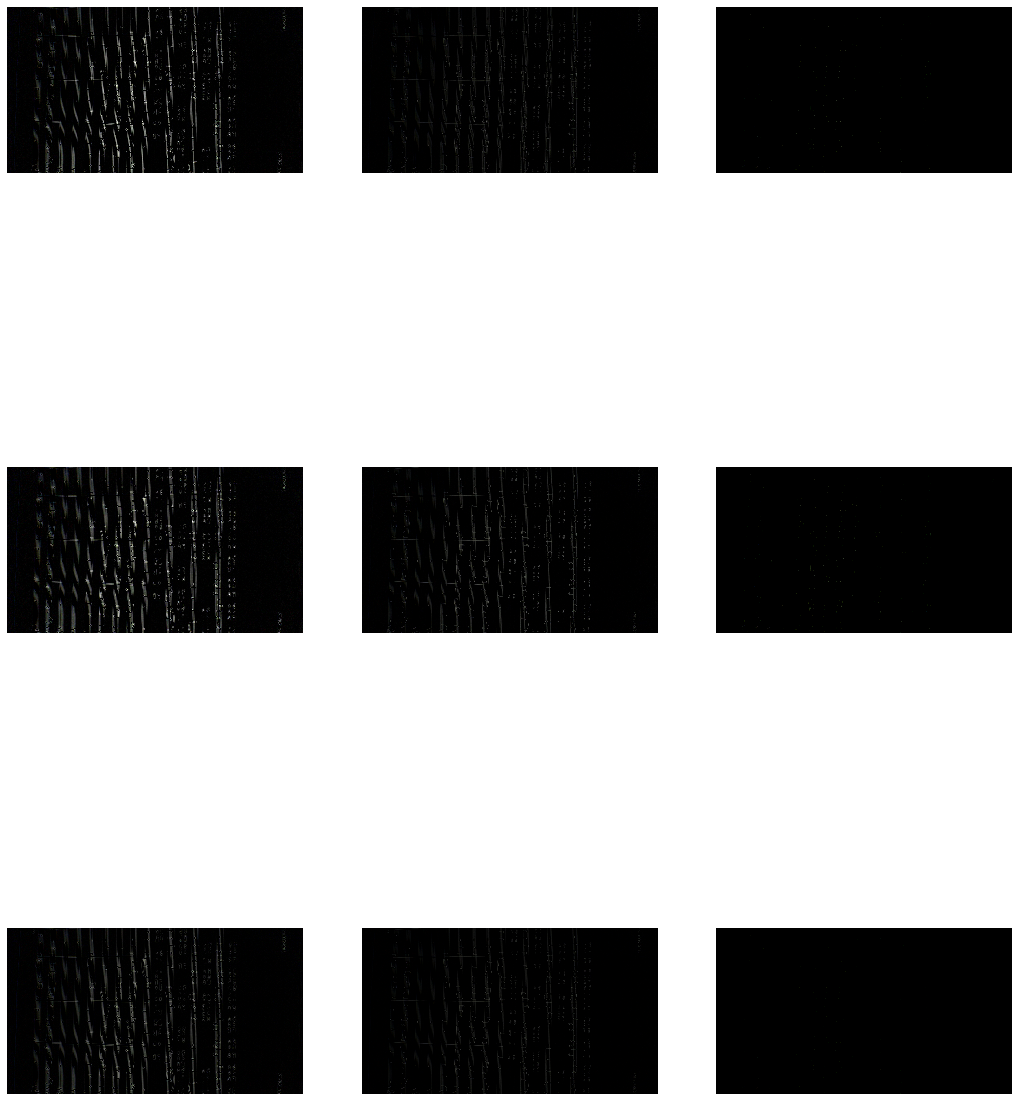

8.873694658279419


In [8]:
t1=time.time()
#ss - liczba obrazków
ss=100

fig, ax=plt.subplots(3,3,figsize=(18,24))

kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])

g=[0]*ss
em=[0]*ss


mo=13
for i in range(9):
    print(i)
    em[i]=f[i]*0
    
    #imgray = cv.cvtColor(f[i], cv.COLOR_BGR2GRAY)
    for a in range(3):
        mg=cv.filter2D(f[mo], -1, kernel[a+4])
        for b in range(3):
            im2=cv.filter2D(mg, -1, kernel[b+1])
            ax[a][b].imshow(im2)
            ax[a][b].axis('off')
    
plt.show()
t2=time.time()
print(t2-t1)

In [ ]:
def colortotuple(x):
    r=int(x[1:3], 16)
    g=int(x[3:5], 16)
    b=int(x[5:7], 16)
    
    return (r, g, b)


t1=time.time()
#ss - liczba obrazków
ss=60

fig, ax=plt.subplots(ss,1,figsize=(18,8*ss))
#kernele do grafiki
kernel1=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel2=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel3=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel4=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel5=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel6=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])

g=[0]*ss
em=[0]*ss
palette=['#FF0101', '#01FF01', '#0101FF', '#FF33BB',
        '#FFFF01', '#FF01FF', '#01FFFF', '#80EAFF',
        '#888801', '#880188', '#018888', '#FFCCDD',
        '#01AACC', '#BFFFE5', '#C4FF4D', '#012B33', 
        '#FF0101', '#01FF01', '#0101FF', '#FF33BB',
        '#FFFF01', '#FF01FF', '#01FFFF', '#80EAFF',
        '#888801', '#880188', '#018888', '#FFCCDD',
        '#01AACC', '#BFFFE5', '#C4FF4D', '#012B33']
p2=[colortotuple(x) for x in palette]

for i in range(ss):
    print(i)
    em[i]=f[i]*0
    
    #imgray = cv.cvtColor(f[i], cv.COLOR_BGR2GRAY)
    mg=cv.filter2D(f[i], -1, kernel6)
    #im2=cv.filter2D(f[i], -1, kernel2)
    im2=cv.filter2D(mg, -1, kernel2)
    ax[i].imshow(im2)
    ax[i].axis('off')
    
plt.show()
t2=time.time()
print(t2-t1)

0
(691, 1229, 3)


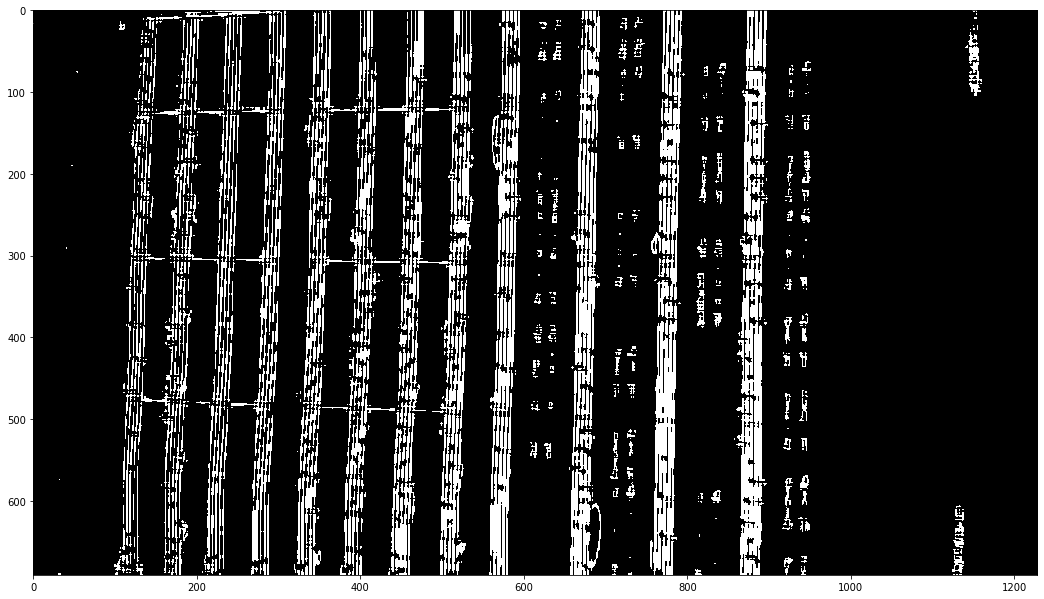

1
(691, 1229, 3)


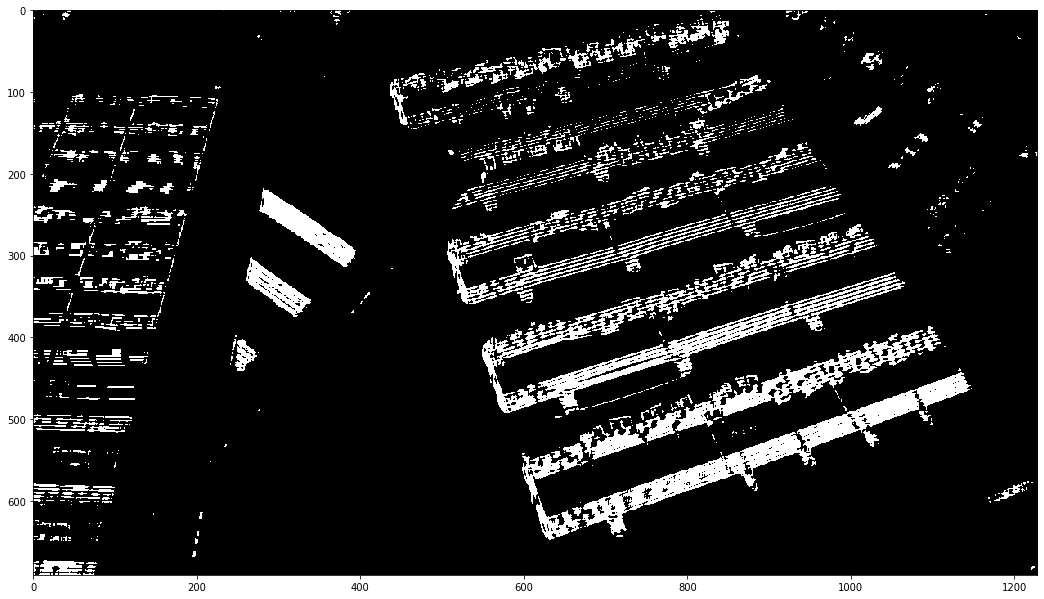

2
(691, 1229, 3)


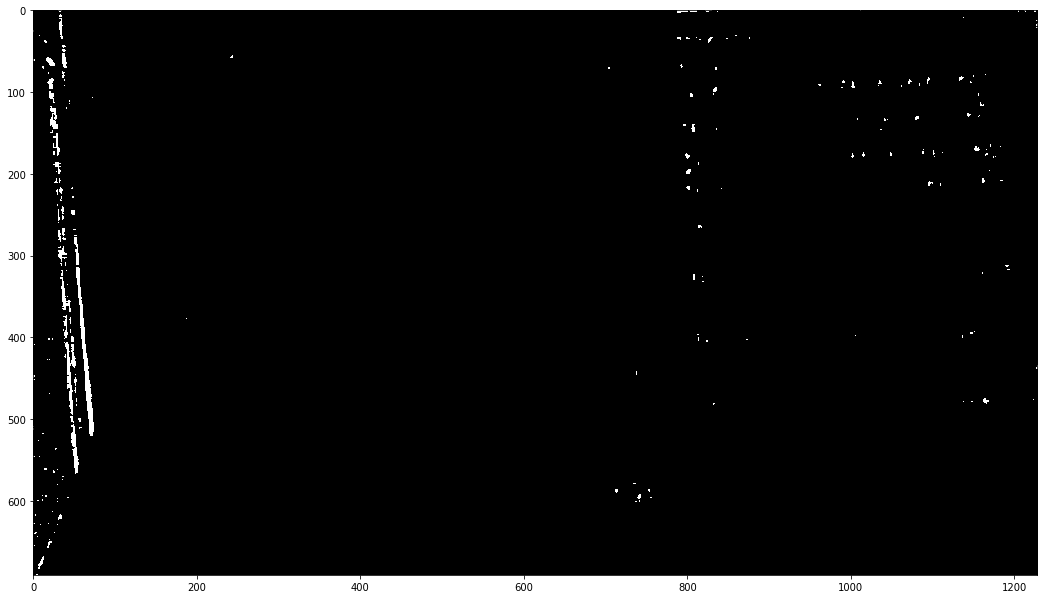

3
(691, 1229, 3)


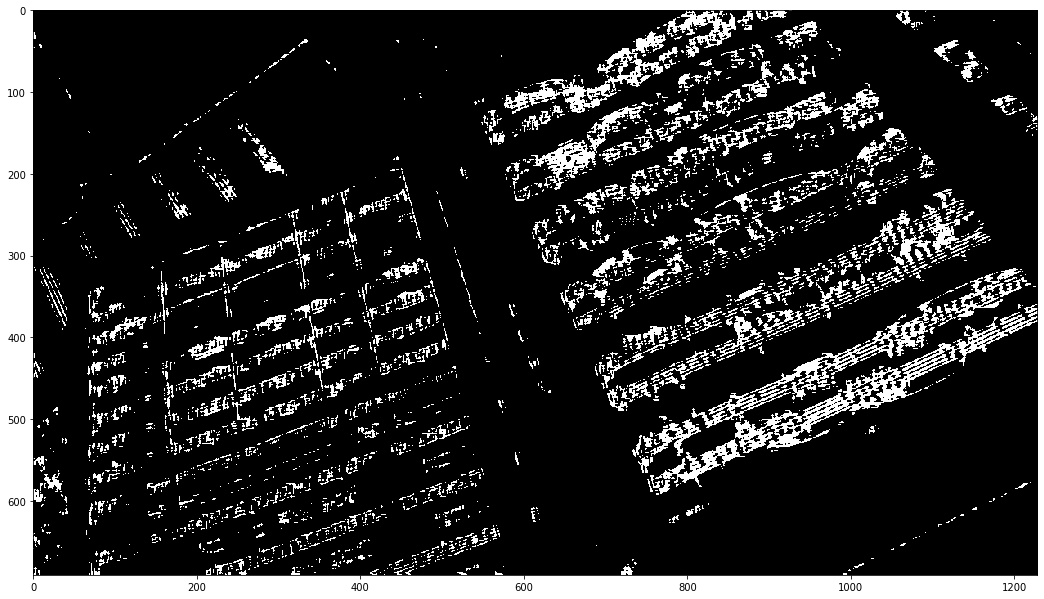

4
(1229, 691, 3)


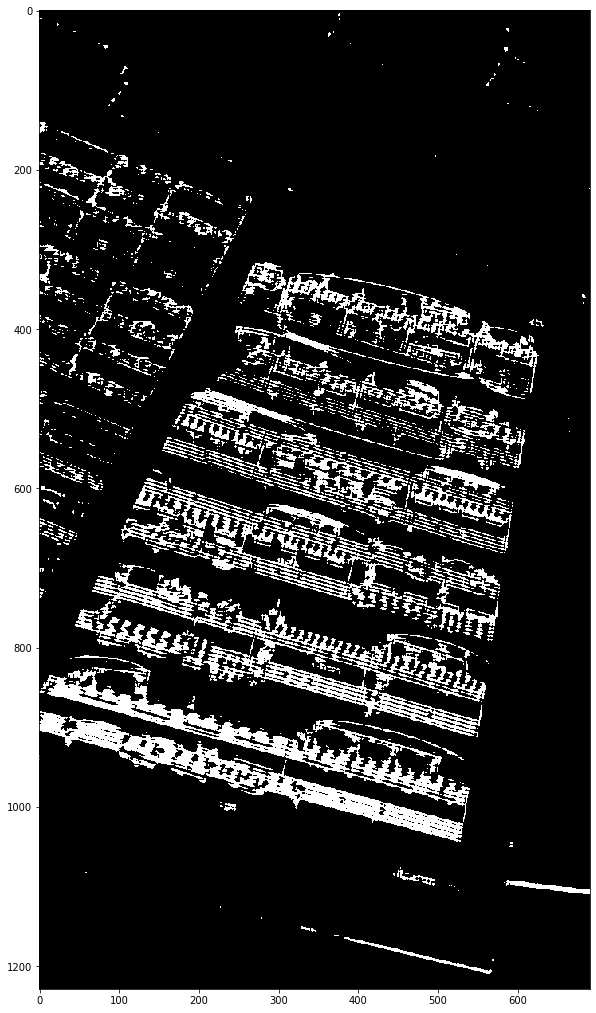

5
(691, 1229, 3)


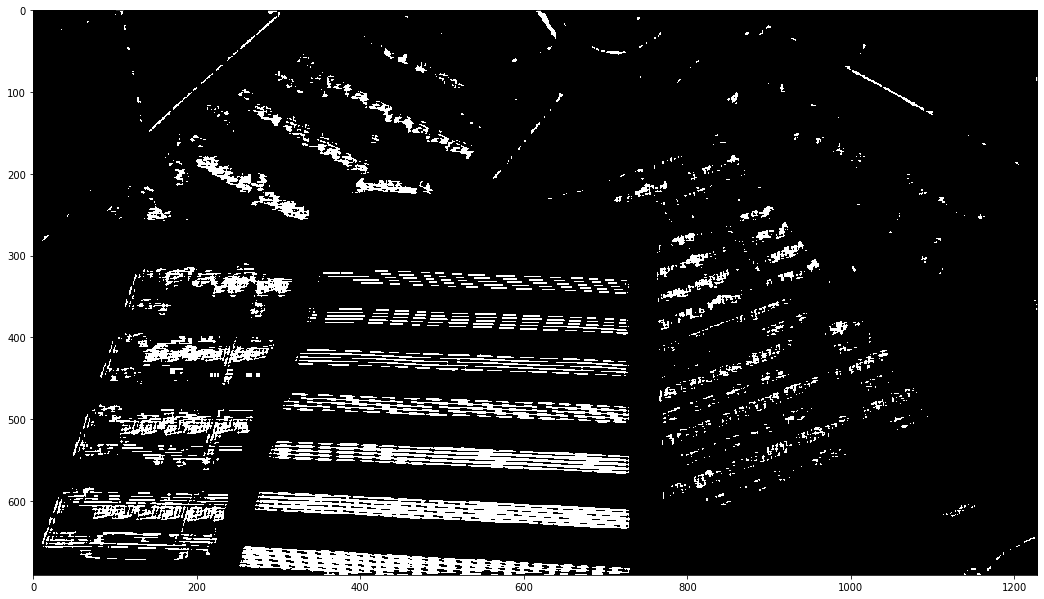

6
(691, 1229, 3)


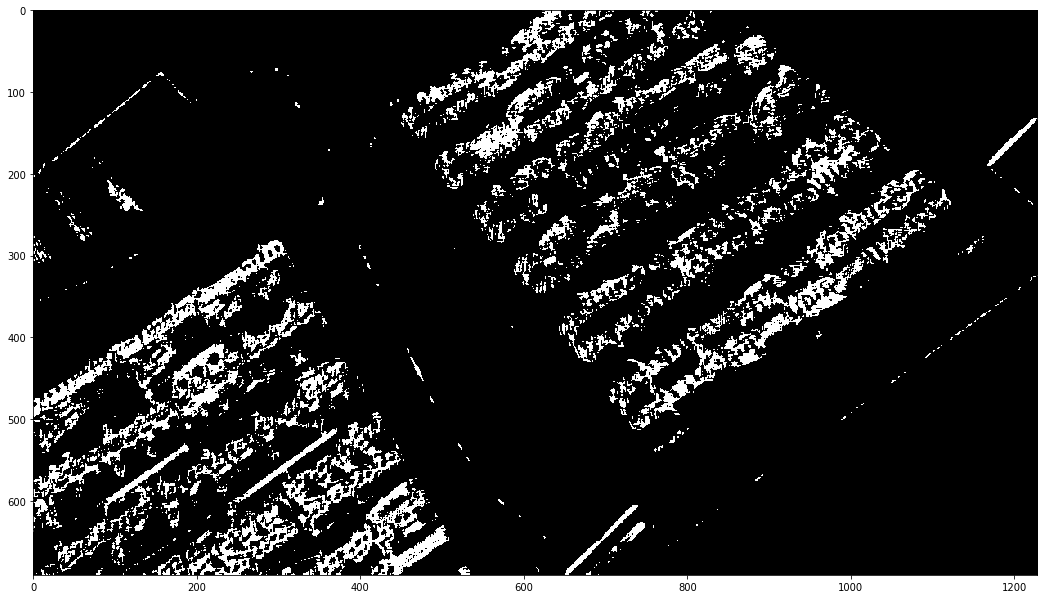

7
(691, 1229, 3)


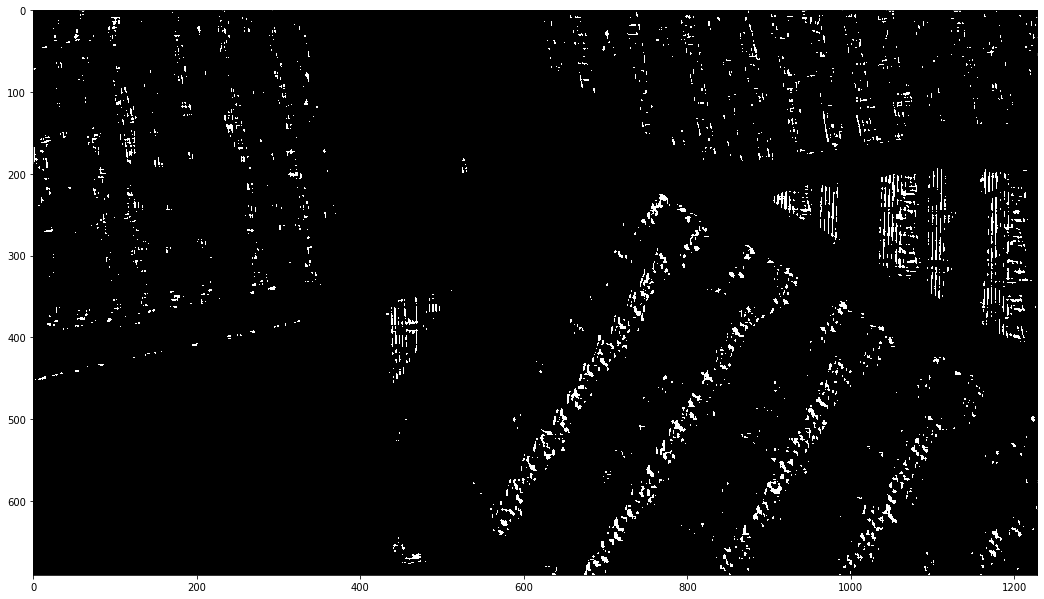

8
(1229, 691, 3)


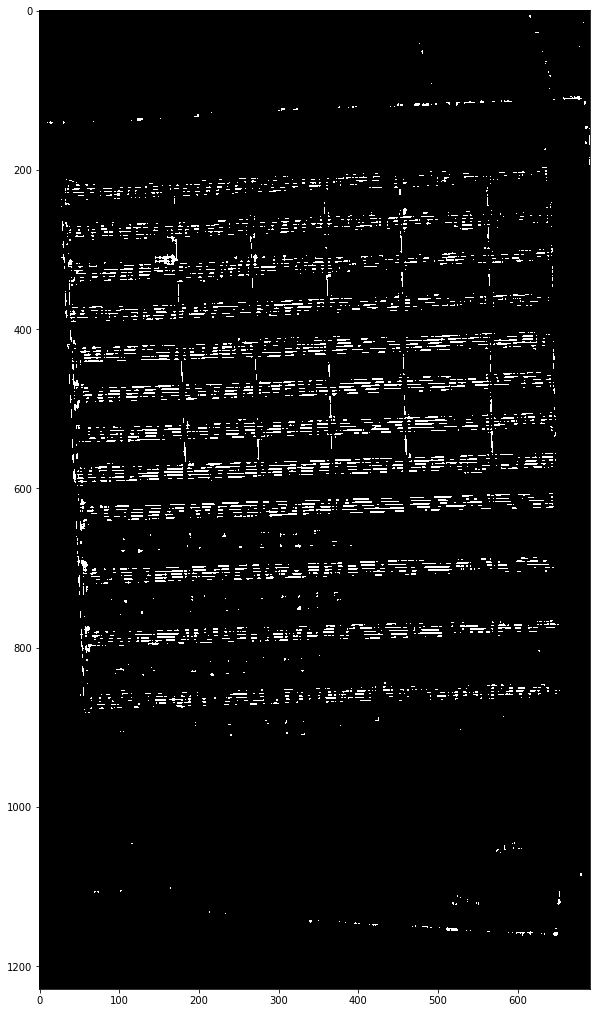

9
(691, 1229, 3)


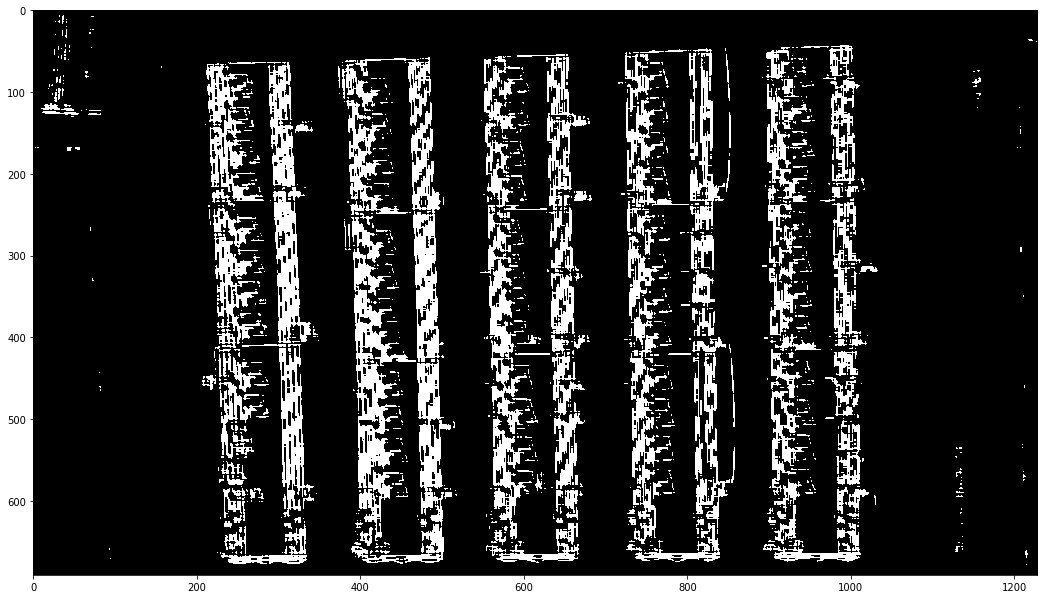

8.937890768051147


In [78]:
t1=time.time()
#ss - liczba obrazków
ss=100


kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])

g=[0]*ss
em=[0]*ss


mo=13
for i in range(10):
    print(i)
    em[i]=f[i]*0
    
    #imgray = cv.cvtColor(f[i], cv.COLOR_BGR2GRAY)
    mg=cv.filter2D(f[mo+i], -1, kernel[5])
    #for b in range(2):
    #    im2=cv.filter2D(mg, -1, kernel[b+1])
    im2=cv.filter2D(mg, -1, kernel[1])

    #im2[:,:,0][im2[:,:,0]<im2[:,:,1]]=im2[:,:,1]
    print(im2.shape)

    ret, thresh = cv.threshold(im2, 0.03, 1, 0)
    em2=cv.filter2D(thresh, -1, kernel[7])
    ret, thresh = cv.threshold(em2, 25, 1, 0)
    em2=overkill(thresh)
    #em2=cv.filter2D(thresh, -1, kernel[7])
    #ret, thresh = cv.threshold(em2, 17, 1, 0)
    #em2=thresh
    grave(em2)
    
t2=time.time()
print(t2-t1)

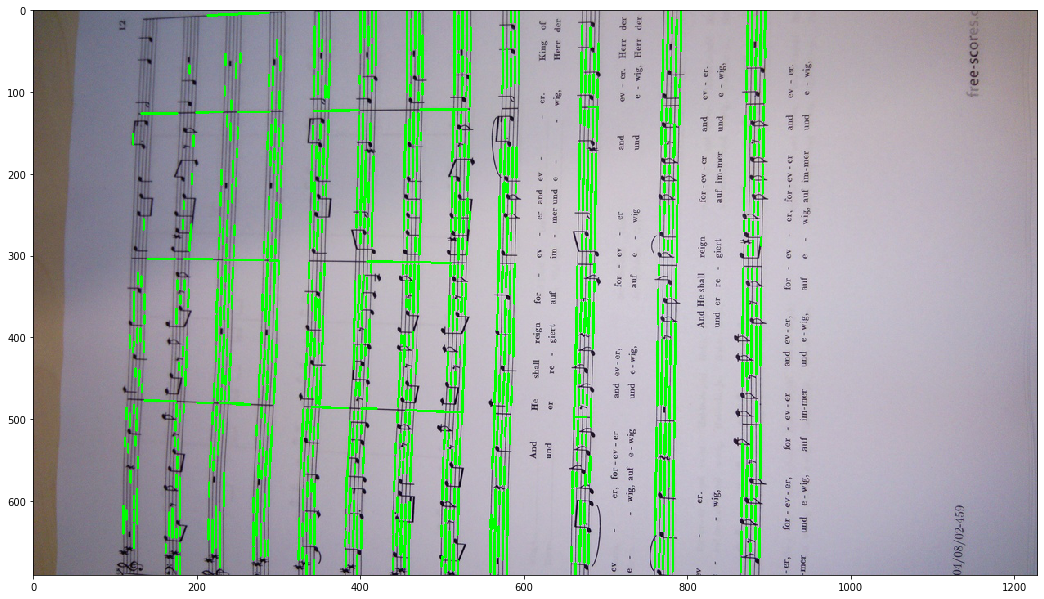

In [147]:
import cv2 as cv
import numpy as np

img = (f[13]*255).astype('uint8').copy()

mg=cv.filter2D(img, -1, kernel[6])
im2=cv.filter2D(mg, -1, kernel[2])

gray = cv.cvtColor(im2,cv.COLOR_BGR2GRAY)
edges=cv.filter2D(gray, -1, kernel[1])
ret, thresh=cv.threshold(edges, 28, 1, 0)
#edges = cv.Canny(gray,50,150,apertureSize = 3)
minLineLength = 1000
maxLineGap = 10
lines = cv.HoughLinesP(thresh,1,np.pi/180,100,minLineLength,maxLineGap)
for iv in lines:
    x1,y1,x2,y2=iv[0]
    cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)

grave(img)


In [87]:
ret, thresh = cv.threshold(f[2], 0.035, 1, 0)
    
#thresh=(thresh*255).astype('uint8')
imgray = cv.cvtColor(thresh, cv.COLOR_BGR2GRAY)

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'
